In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM


In [2]:
def error_rate(original, prediction, ft_len, forecast_len):
    error_avg = []
    ft_len = ft_len-1
    for i in range(forecast_len):
      error = abs((original[ft_len+i] - prediction[-forecast_len+i]))/original[ft_len+i] * 100
      print('num',i,error,'actual',original[ft_len+i],'prediction',prediction[-forecast_len+i])
      print("오차율 :",error)
      error_avg.append(error)
    print('최소 오류값 :',min(error_avg))
    print('최대 오류값 :',max(error_avg))
    return sum(error_avg)/len(error_avg)

def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P
# Initialization for system model.
A = 1
H = 1
Q = 0.0001
R = 0.001
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - (window_size+20)):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size+20]))
    return np.array(feature_list), np.array(label_list)

In [5]:
import os
os.chdir('/content/drive/MyDrive/Data/Danger_Cell')
os.getcwd()
cells = os.listdir()
len(cells)

164

In [6]:
final_train_feature=[]
final_train_label=[]
for cell in cells:
  # 학습시킬 Cell 호출
  df = pd.read_csv(cell, encoding='utf8')
  df = df['ResistValue']
  # 칼만 필터 적용하여 학습
  n_samples=len(df)
  x_esti, P = None, None
  esti_save = np.zeros(n_samples)
  x_0 = df[0]
  P_0 = 1
  for i in range(n_samples):
      if i == 0:
          x_esti, P = x_0, P_0
      else:
          x_esti, P = kalman_filter(df[i], x_esti, P)
      esti_save[i] = x_esti
  x_train = esti_save
  y_train = esti_save
  x_train = pd.DataFrame(x_train)
  y_train = pd.DataFrame(y_train)

  # fitting
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  y_train = scaler.fit_transform(y_train)
  x_train = pd.DataFrame(x_train)
  y_train = pd.DataFrame(y_train)

  # make_dataset
  lookback = 20
  train_feature, train_label = make_dataset(x_train, y_train, lookback)
  if len(final_train_feature)==0:
    final_train_feature=train_feature
    final_train_label=train_label
  else:
#    final_train_feature=np.array(final_train_feature)
#    final_train_label=np.array(final_train_label)
    final_train_feature = np.concatenate((final_train_feature, train_feature),axis=0)
    final_train_label = np.concatenate((final_train_label, train_label),axis=0)


In [7]:
print(final_train_feature.shape)

(40198, 20, 1)


In [ ]:
model= Sequential()
model.add(LSTM(64, input_shape=(final_train_feature.shape[1], final_train_feature.shape[2]), 
               activation='relu'))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.summary()

from keras.callbacks import EarlyStopping
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop=EarlyStopping(monitor='mse', patience=20)

model.fit(final_train_feature, final_train_label, epochs=100, batch_size=1, callbacks=[early_stop])
model.save('Train_With_Danger_Cells.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 23,169
Trainable params: 23,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
40198/40198 [==============================] - 214s 5ms/step - loss: 0.0110 - mse: 0.0110
Epoch 2/100
40198/40198 [==============================] - 217s 5ms/step - loss: 0.0093 - mse: 0.0093
Epoch 3/100
40198/40198 [===================

In [10]:
import os
os.getcwd()

'/content/drive/MyDrive/Data/Danger_Cell'

train_feature shape  (488, 20, 1)
prediction shape  (488, 1)


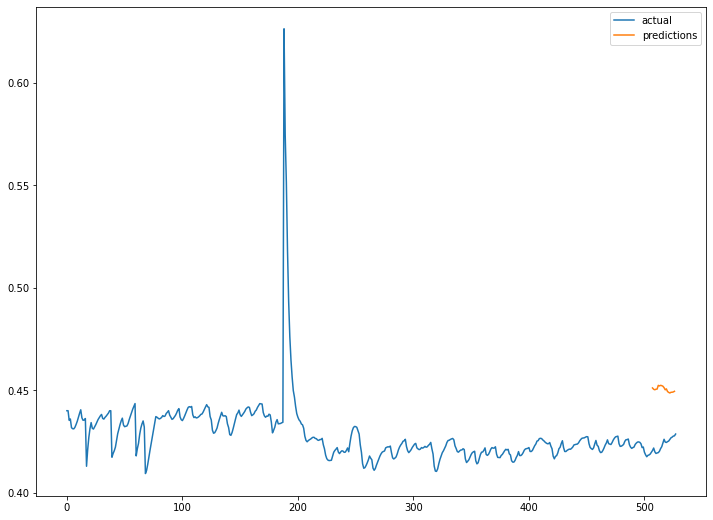

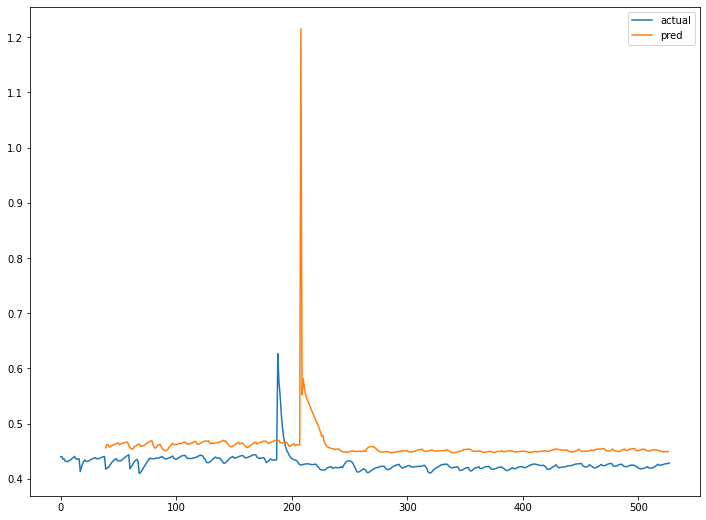

num 0 [6.59568266] actual [0.42319158] prediction [0.45110396]
오차율 : [6.59568266]
num 1 [6.18406155] actual [0.42422045] prediction [0.4504545]
오차율 : [6.18406155]
num 2 [5.73852528] actual [0.42578183] prediction [0.45021543]
오차율 : [5.73852528]
num 3 [6.25967615] actual [0.42394968] prediction [0.45048755]
오차율 : [6.25967615]
num 4 [6.34277967] actual [0.42369312] prediction [0.45056704]
오차율 : [6.34277967]
num 5 [6.81531463] actual [0.42350587] prediction [0.45236912]
오차율 : [6.81531463]
num 6 [6.50898641] actual [0.42444983] prediction [0.4520772]
오차율 : [6.50898641]
num 7 [6.27164277] actual [0.42567909] prediction [0.45237616]
오차율 : [6.27164277]
num 8 [6.01245507] actual [0.42657625] prediction [0.45222396]
오차율 : [6.01245507]
num 9 [5.78501166] actual [0.42723104] prediction [0.4519464]
오차율 : [5.78501166]
num 10 [5.56845332] actual [0.42743878] prediction [0.4512405]
오차율 : [5.56845332]
num 11 [5.28580088] actual [0.4275904] prediction [0.45019197]
오차율 : [5.28580088]
num 12 [6.30627596]

In [23]:
df=pd.read_csv('../m2_s2_bank_fc3d2b581285134ea7b13a850adfc373__site_1239fca6caf920448b3cd13f6a2997af.csv')
df=df[df['CellNo']==24].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2
forecasting=20
train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)
predictions = model.predict(train_feature2)

print("train_feature shape ", train_feature2.shape)
print("prediction shape ", predictions.shape)


# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[forecasting+19:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

train_feature shape  (488, 20, 1)
prediction shape  (488, 1)


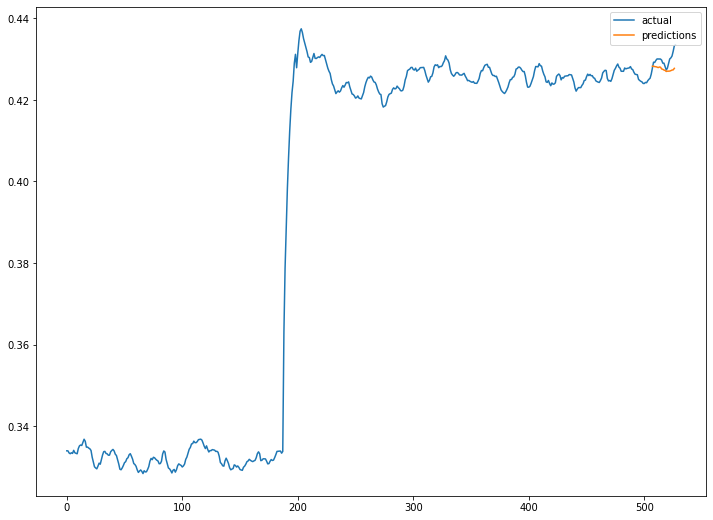

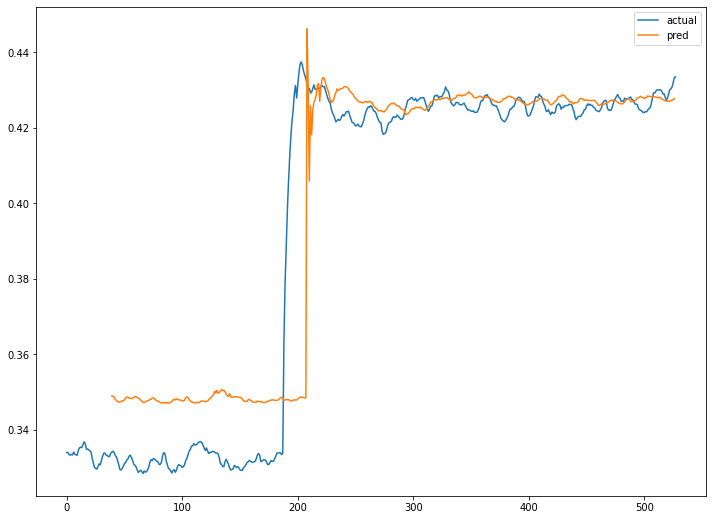

num 0 [0.22763945] actual [0.42725566] prediction [0.42822826]
오차율 : [0.22763945]
num 1 [0.2541344] actual [0.42718659] prediction [0.42827222]
오차율 : [0.2541344]
num 2 [0.68101195] actual [0.42524509] prediction [0.42814106]
오차율 : [0.68101195]
num 3 [0.81993302] actual [0.42463856] prediction [0.42812032]
오차율 : [0.81993302]
num 4 [0.77750839] actual [0.42473621] prediction [0.42803857]
오차율 : [0.77750839]
num 5 [0.79373547] actual [0.42453732] prediction [0.42790702]
오차율 : [0.79373547]
num 6 [0.6700323] actual [0.42520263] prediction [0.42805162]
오차율 : [0.6700323]
num 7 [0.4183684] actual [0.42622851] prediction [0.42801172]
오차율 : [0.4183684]
num 8 [0.07542611] actual [0.4272474] prediction [0.42756966]
오차율 : [0.07542611]
num 9 [0.05285057] actual [0.42772088] prediction [0.42749482]
오차율 : [0.05285057]
num 10 [0.23979105] actual [0.4283366] prediction [0.42730948]
오차율 : [0.23979105]
num 11 [0.36537425] actual [0.42878598] prediction [0.4272193]
오차율 : [0.36537425]
num 12 [0.25025143] act

In [21]:
df=pd.read_csv('../m2_s2_bank_fc3d2b581285134ea7b13a850adfc373__site_1239fca6caf920448b3cd13f6a2997af.csv')
df=df[df['CellNo']==20].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2
forecasting=20
train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)
predictions = model.predict(train_feature2)

print("train_feature shape ", train_feature2.shape)
print("prediction shape ", predictions.shape)


# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[forecasting+19:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

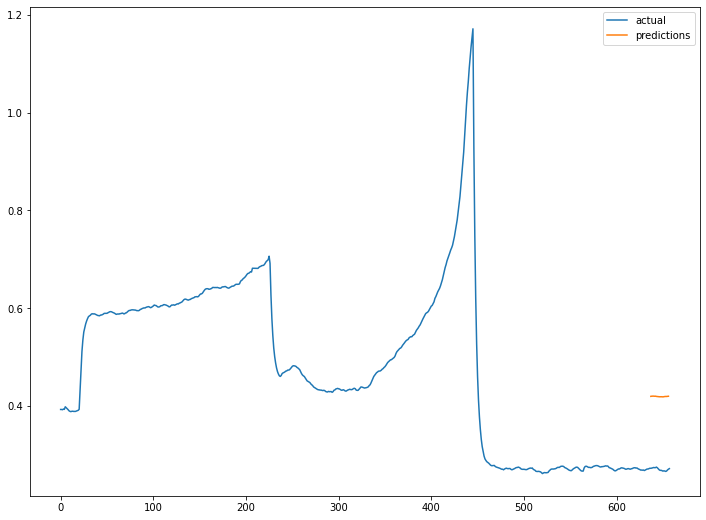

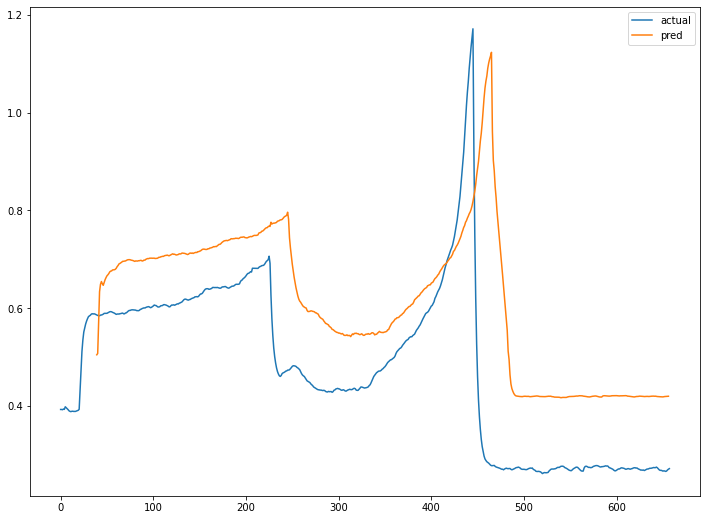

num 0 [55.37796333] actual [0.26958372] prediction [0.4188737]
오차율 : [55.37796333]
num 1 [56.52861582] actual [0.26780509] prediction [0.4191916]
오차율 : [56.52861582]
num 2 [57.33155189] actual [0.26650696] prediction [0.41929954]
오차율 : [57.33155189]
num 3 [57.41836573] actual [0.26637] prediction [0.4193153]
오차율 : [57.41836573]
num 4 [56.59818117] actual [0.26762083] prediction [0.41908935]
오차율 : [56.59818117]
num 5 [55.95326427] actual [0.26880389] prediction [0.41920844]
오차율 : [55.95326427]
num 6 [54.97588397] actual [0.27020765] prediction [0.4187567]
오차율 : [54.97588397]
num 7 [54.91691024] actual [0.27015155] prediction [0.41851044]
오차율 : [54.91691024]
num 8 [54.25176257] actual [0.27119123] prediction [0.41831726]
오차율 : [54.25176257]
num 9 [53.40484197] actual [0.27249035] prediction [0.4180134]
오차율 : [53.40484197]
num 10 [53.49801447] actual [0.27235788] prediction [0.41806394]
오차율 : [53.49801447]
num 11 [53.67290318] actual [0.27199104] prediction [0.41797653]
오차율 : [53.67290318

In [12]:
df=pd.read_csv('../m2_s2_bank_0765f177a52e5543a9e0a8bfc045cf6a__site_40ab7c891c559b478e96f8bb5c682ca0.csv')
df=df[df['CellNo']==20].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save
scale_cols=['ResistValue']
x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2
forecasting=20
train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[forecasting+19:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)

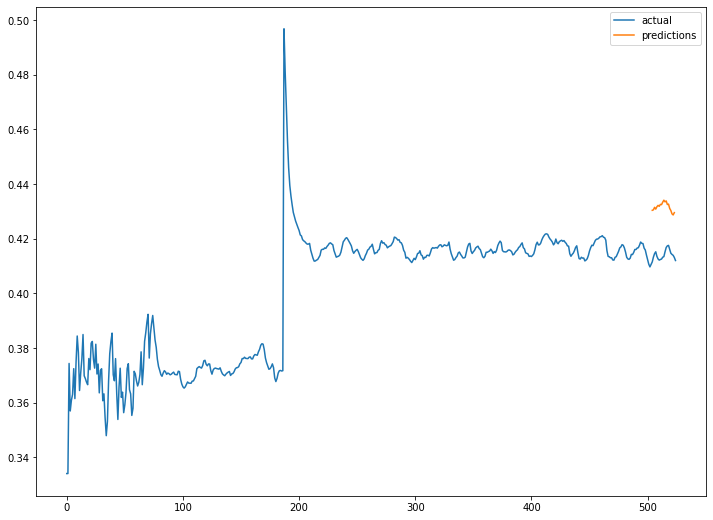

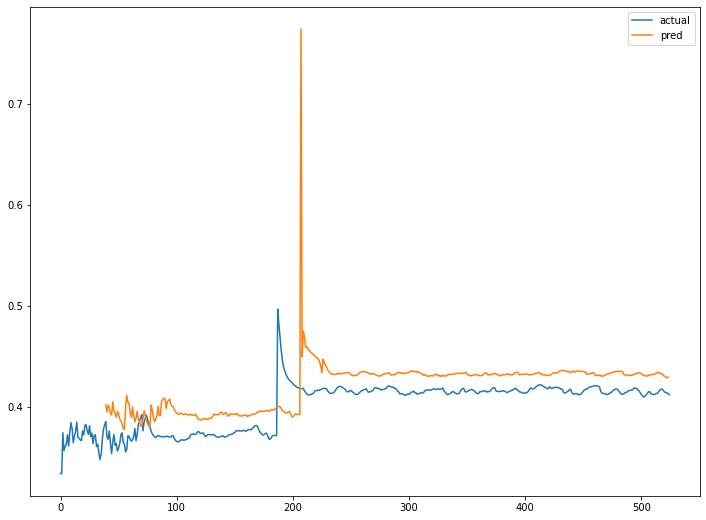

num 0 [2.37892487] actual [0.42038428] prediction [0.4303849]
오차율 : [2.37892487]
num 1 [2.64249063] actual [0.41946999] prediction [0.43055445]
오차율 : [2.64249063]
num 2 [3.83367571] actual [0.41556084] prediction [0.4314921]
오차율 : [3.83367571]
num 3 [4.18403071] actual [0.41351823] prediction [0.43081996]
오차율 : [4.18403071]
num 4 [4.42898832] actual [0.41337823] prediction [0.4316867]
오차율 : [4.42898832]
num 5 [4.64501867] actual [0.41300589] prediction [0.4321901]
오차율 : [4.64501867]
num 6 [4.56072061] actual [0.4130043] prediction [0.43184027]
오차율 : [4.56072061]
num 7 [4.93890188] actual [0.41219267] prediction [0.43255046]
오차율 : [4.93890188]
num 8 [4.93116307] actual [0.41214062] prediction [0.43246394]
오차율 : [4.93116307]
num 9 [4.88572762] actual [0.41318325] prediction [0.43337026]
오차율 : [4.88572762]
num 10 [5.00480978] actual [0.4134039] prediction [0.43409398]
오차율 : [5.00480978]
num 11 [4.60916561] actual [0.41437541] prediction [0.43347466]
오차율 : [4.60916561]
num 12 [4.44676256] 

In [17]:
df=pd.read_csv('../m2_s2_bank_fc3d2b581285134ea7b13a850adfc373__site_1239fca6caf920448b3cd13f6a2997af.csv')
df=df[df['CellNo']==78].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2
forecasting=20
train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)
predictions = model.predict(train_feature2)

# Inversing
predictions = scaler.inverse_transform(predictions)
x_test2 = scaler.inverse_transform(x_test2)


feature_len = len(x_test2)-1 
plot_len = feature_len-20

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[plot_len:], predictions[-20:], label='predictions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
plt.plot(x_test2[:], label ='actual')
plt.plot(x_data[forecasting+19:],predictions, label='pred')
plt.legend()
plt.show()


feature_len = len(train_feature2) - 1
plot_len = feature_len-20
error= error_rate(x_test2, predictions, plot_len, 20)
print('평균 오차율 :',error)